BVP

laplace equation
drichlet bc over disk of radius 1 units around center (0, 0)
least 10 eigenvalues and eigenfunctions

In [1]:
import numpy as np
import ufl
from mpi4py import MPI
from petsc4py import PETSc
from slepc4py import SLEPc
import pyvista as pv
from dolfinx import mesh, fem, plot
# import pyvista as pv
# pv.start_xvfb()



In [2]:
# opts = PETSc.Options()
# opts["mat_type"] = "aijcusparse"
# opts["vec_type"] = "cuda"
# from petsc4py import PETSc
# print(PETSc.Sys.getVersion())
# print(PETSc.compiled_with_cuda()) 

create a domain. We need circle. using gmsh to create domain extenally and loading to fenics!

In [3]:
import gmsh
gmsh.initialize()

In [4]:
disk_radius = 2
eigen_count = 5

In [5]:

disk = gmsh.model.occ.addDisk(0, 0, 0, disk_radius, disk_radius)
# gmsh.model.occ.addD
gmsh.model.occ.synchronize()


In [6]:
gdim = 2
gmsh.model.addPhysicalGroup(gdim, [disk], 1)


1

In [7]:
# gmsh.option.setNumber("Mesh.CharacteristicLengthMin", 0.03)
# gmsh.option.setNumber("Mesh.CharacteristicLengthMax", 0.03)
gmsh.option.setNumber("Mesh.MeshSizeMin", 0.05)
gmsh.option.setNumber("Mesh.MeshSizeMax", 0.05)


gmsh.model.mesh.generate(gdim)


Info    : Meshing 1D...
Info    : Meshing curve 1 (Ellipse)
Info    : Done meshing 1D (Wall 0.000494472s, CPU 0.000776s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.241961s, CPU 0.23749s)
Info    : 6015 nodes 12029 elements


In [8]:
from dolfinx.io import gmshio 
domain, cell_markers, facet_markers = gmshio.model_to_mesh(model=gmsh.model, comm=MPI.COMM_WORLD,rank= 0, gdim=gdim)

In [9]:
domain

Got disk domain!, create function space


In [10]:
V = fem.functionspace(domain, ("Lagrange", 1))

setting the boundary conditions
as our boundary is circle
so we'll set the boundary as sqrt(x2+y2) = 1

In [11]:
def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), disk_radius)

boundary_dofs = fem.locate_dofs_geometrical(V, on_boundary)

as our u = 0 at boundary, we have drichlet condition

In [12]:
from petsc4py import PETSc
default_scalar_type = PETSc.ScalarType

bc = fem.dirichletbc(default_scalar_type(0), boundary_dofs, V)

In [13]:
#define biliear and linear forms
u, v = ufl.TrialFunction(V), ufl.TestFunction(V)
a = fem.form(ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx)
m = fem.form(ufl.inner(u, v) * ufl.dx)

In [14]:
import dolfinx.fem.petsc
# 4. Assemble matrices A and M
A = fem.petsc.assemble_matrix(a, bcs=[bc]) #bc only on stiffness matrix
A.assemble()
M = fem.petsc.assemble_matrix(m)
M.assemble()

In [21]:
eigensolver = SLEPc.EPS().create()
eigensolver.setOperators(A, M)
eigensolver.setProblemType(SLEPc.EPS.ProblemType.GHEP) # General Hermitian
eigensolver.setDimensions(nev=eigen_count)
eigensolver.setTolerances(tol=1e-8)
# eigensolver.setWhichEigenpairs(SLEPc.EPS.Which.SMALLEST_MAGNITUDE)
eigensolver.setWhichEigenpairs(2)
eigensolver.solve()

eigensolver = SLEPc.EPS().create()
eigensolver.setOperators(A, M)
eigensolver.setProblemType(SLEPc.EPS.ProblemType.GHEP)

# Shift-and-invert to avoid the nullspace (zero eigenvalue)
eigensolver.setWhichEigenpairs(SLEPc.EPS.Which.TARGET_REAL)
# eigensolver.setTarget(1e-6)  # Small positive shift
# ST = eigensolver.getST()
# ST.setType(SLEPc.ST.Type.SINVERT)
# ST.setShift(1e-6)

# Solver settings for robustness
eigensolver.setType(SLEPc.EPS.Type.KRYLOVSCHUR)  # or SLEPc.EPS.Type.JD
eigensolver.setDimensions(nev=eigen_count, ncv=2*eigen_count)  # Larger subspace
eigensolver.setTolerances(tol=1e-8, max_it=1000)
eigensolver.setFromOptions()
eigensolver.solve()


In [22]:
n_conv = eigensolver.getConverged()
if MPI.COMM_WORLD.rank == 0:
    print(f"Number of converged eigenvalues: {n_conv}")

Number of converged eigenvalues: 1


In [23]:
import matplotlib.pyplot as plt
import numpy as np
import dolfinx.plot

def plot_eigenfunctions(domain, V, eigensolver, A, n_conv, nev_to_plot=6):
    """
    Plot the first few eigenfunctions for any given domain using matplotlib.
    Parameters:
        domain: dolfinx.mesh.Mesh
        V: dolfinx.fem.FunctionSpace
        eigensolver: SLEPc.EPS
        A: PETSc.Mat (needed for getVecs)
        n_conv: int (number of converged eigenpairs)
        nev_to_plot: int (number of eigenfunctions to plot)
    """
    if MPI.COMM_WORLD.rank != 0:
        return

    topology, cell_types, geometry = dolfinx.plot.vtk_mesh(domain)
    points = geometry

    # Set up grid for plotting multiple eigenfunctions
    nrows = int(np.ceil(np.sqrt(nev_to_plot)))
    ncols = int(np.ceil(nev_to_plot / nrows))
    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = axes.flatten()

    for i in range(min(nev_to_plot, n_conv)):
        eigval = eigensolver.getEigenvalue(i)
        error = eigensolver.computeError(i)
        print(f"Eigenvalue {i}: {eigval:.4f} (Error: {error:.2e})")

        r, _ = A.getVecs()
        eigensolver.getEigenvector(i, r)
        uh = fem.Function(V)
        uh.x.petsc_vec.array = r.array
        uh.x.petsc_vec.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

        # Plot using matplotlib's tricontourf for smooth color
        ax = axes[i]
        tcf = ax.tricontourf(points[:, 0], points[:, 1], uh.x.array.real, levels=50, cmap='jet')
        ax.set_title(f"Eigenfunction {i}\n$\lambda$ = {eigval.real:.4f}", fontsize=12)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        ax.set_aspect('equal')
        fig.colorbar(tcf, ax=ax, orientation='vertical', shrink=0.8)

    # Hide unused subplots
    for j in range(i + 1, nrows * ncols):
        fig.delaxes(axes[j])

    plt.suptitle("Laplace Eigenfunctions", fontsize=16, weight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Usage example (after solving eigenproblem):
# plot_eigenfunctions(domain, V, eigensolver, A, n_conv, nev_to_plot=6)


Eigenvalue 0: 1.4461 (Error: 5.00e-08)
Eigenvalue 1: 3.6726 (Error: 1.86e-08)
Eigenvalue 2: 3.6726 (Error: 1.37e-08)
Eigenvalue 3: 6.6004 (Error: 9.43e-09)
Eigenvalue 4: 6.6004 (Error: 4.53e-09)


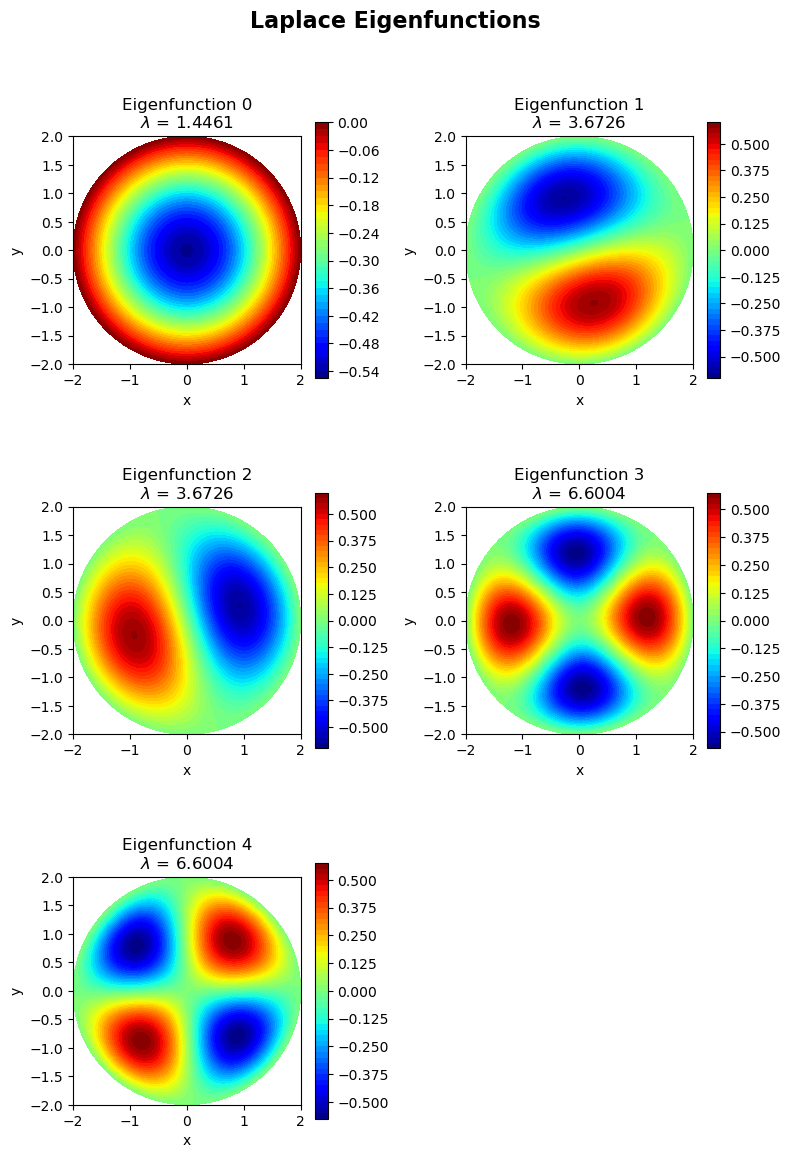

In [18]:
plot_eigenfunctions(domain, V, eigensolver, A, n_conv, nev_to_plot=eigen_count)

In [19]:
# # 5. Solve the generalized eigenvalue problem A u = λ M u
# eigensolver = SLEPc.EPS().create()
# eigensolver.setOperators(A, M)
# # eigensolver.setProblemType(SLEPc.EPS.ProblemType.HEP)
# eigensolver.setProblemType(SLEPc.EPS.ProblemType.GHEP)
# eigensolver.setWhichEigenpairs(2) # set 1 for maximum eigenvalues
# eigensolver.setDimensions(nev=10)  # Get 10 eigenvalues
# eigensolver.setFromOptions()
# eigensolver.solve()
# # eigensolver.setTolerances(1e-6)

# n_conv = eigensolver.getConverged()
# if MPI.COMM_WORLD.rank == 0:
#     print(f"Number of converged eigenvalues: {n_conv}")


In [20]:
# # 6. Extract and plot first few eigenfunctions
# if MPI.COMM_WORLD.rank == 0:
#     topology, cell_types, geometry = plot.vtk_mesh(V)
#     points = domain.geometry.x
#     for i in range(n_conv):
#         eigval = eigensolver.getEigenvalue(i)
#         print(f"Eigenvalue {i}: {eigval:.4f}")

#         r, _ = A.getVecs()
#         eigensolver.getEigenvector(i, r)

#         uh = fem.Function(V)
#         uh.x.petsc_vec.setArray(r.array)
#         uh.x.petsc_vec.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)

#         # Create PyVista grid
#         values = uh.x.array.real
#         grid = pv.UnstructuredGrid(topology, cell_types, points)
#         grid.point_data["u"] = values

#         # Plot
#         plotter = pv.Plotter(notebook=True)
#         plotter.add_mesh(grid, show_edges=True, scalars="u", cmap="jet")
#         plotter.view_xy()
#         plotter.add_text(f"Eigenfunction {i}, λ = {eigval:.2f}", font_size=12)
#         plotter.show()
